## proof of concept for EMT decision-support

In [638]:
import numpy as np
import matplotlib.pyplot as plt

In [651]:
class Patient:
    def __init__(self,location,health):
        self.health = health
        self.location = location
        self.status = 0

class ICU:
    def __init__(self,name,metadata): # passed ICU metadata
        self.name = name
        self.max_beds = metadata['max_beds']
        self.max_ventilators = metadata['max_ventilators']
        self.used_beds = 0
        self.used_ventilators = 0
    def updateUsed(self,delta_beds=1, delta_ventilators=0):
        self.used_beds += delta_beds
        self.used_ventilators += delta_ventilators
    
class ED:
    def __init__(self,name,metadata): # passed ER metadata
        self.name = name
        self.max_beds = metadata['max_beds']
        self.used_beds = 0
    def updateUsed(self,delta_beds=1):
        self.used_beds += delta_beds
        
class Hospital:
    def __init__(self,name,metadata): # passed hospital metadata
        self.name = name 
        self.location = metadata['location']
        self.ICU = ICU(name=self.name,metadata=metadata['ICU'])
        self.ED = ED(name=self.name,metadata=metadata['ED'])
        self.patients = []
    def distanceToPatient(self,location):
        return np.linalg.norm(self.location-location)
    def updateUsedED(self,delta_beds=1):
        self.ED.updateUsed(delta_beds=delta_beds)
    def updateUsedICU(self,delta_beds=1, delta_ventilators=1):
        self.ICU.updateUsed(delta_beds=delta_beds,delta_ventilators=delta_ventilators)
    def availableBedED(self):
        return self.ED.max_beds-self.ED.used_beds
    def availableBedICU(self):
        return self.ICU.max_beds-self.ICU.used_beds
    def availableVentilatorICU(self):
        return self.ICU.max_ventilators-self.ICU.used_ventilators
    def admitToED(self,delta_beds=1,patient=None):
        self.ED.updateUsed(delta_beds=delta_beds)
        if (patient != None):
            self.patients.append(patient)
    def admitToICU(self,delta_beds=1,patient=None):
        self.ED.updateUsed(delta_beds=-delta_beds)
        self.ICU.updateUsed(delta_beds=delta_beds)
    def dischargefromED(self,delta_beds=1,patient=None):
        self.ED.updateUsed(delta_beds=-delta_beds)
        if (patient != None):
            self.patients.remove(patient)
    def dischargefromICU(self,delta_beds=1,patient=None):
        self.ICU.updateUsed(delta_beds=-delta_beds)
        if (patient != None):
            self.patients.remove(patient)
    
class City:
    def __init__(self,metadata): # all metadata
        self.hospitals = []
        for name in metadata.keys():
            self.hospitals.append(Hospital(name=name,metadata=metadata[name]))
    # naive implemtnation
    def new_patient_naive(self,patient):
        distances = []
        for hospital in self.hospitals:
            distances += [hospital.distanceToPatient(patient.location)]
        found = False
        ind = 0
        while found == False and ind < len(self.hospitals): 
            h = self.hospitals[np.argsort(distances)[ind]]
            if h.availableBedED() > 0:
                found = True
                h.admitToED(patient=patient)
            ind += 1
        if (found == False):
            #print('city EDs oversaturated')
            return 0
        return h
    # communication implementation
    def new_patient(self,patient):
        metric = []
        for hospital in self.hospitals:
            metric += [1.0/(hospital.availableBedED()+1)] # could be whatever metric
        found = False
        ind = 0
        while found == False and ind < len(self.hospitals): 
            h = self.hospitals[np.argsort(metric)[ind]]
            if h.availableBedED() > 0:
                found = True
                h.admitToED(patient=patient)
            ind += 1
        if (found == False):
            #print('city EDs oversaturated')
            return 0
        return h

In [700]:
def createPatient():
    location = np.asarray([np.random.random(),np.random.random()])
    health = np.random.random()
    patient = Patient(location=location,health=health)
    return patient

def simulate(city,city2=None,model=None):
    edwt = np.zeros(nP*nH).reshape([nH,nP])
    dwt = np.zeros(nP)
    edwt2 = np.zeros(nP*nH).reshape([nH,nP])
    dwt2 = np.zeros(nP)
    for trial in range(nT):
        for i in range(nP):
            patient = createPatient()
            if (city2 == None):
                if (model == 'naive'):
                    hos = city.new_patient_naive(patient)
                else:
                    hos = city.new_patient(patient)
                if (hos==0):
                    break
                # admit patients with health less than 0.25 to ICU
                if (patient.health<=0.05):
                    hos.admitToICU()
                # discharge patients with health greather than 0.75
                if (patient.health>=0.95):
                    hos.dischargefromED()
                # update probabilistic department admits/disharges
                for j in range(len(city.hospitals)):
                    numDischargedED = np.random.exponential(1)
                    numAdmitICU = np.random.exponential(1)
                    numDishargedICU = np.random.exponential(1)
                    if (np.random.random()<0.05 and numDischargedED<city.hospitals[j].ED.used_beds):
                        city.hospitals[j].dischargefromED(numDischargedED)
                    # update stats
                    edwt[j,i] += city.hospitals[j].availableBedED()/nT
                dwt[i] += hos.distanceToPatient(patient.location)/nT
            else:
                hos = city.new_patient(patient)
                if (hos==0):
                    break
                else:
                    # admit patients with health less than 0.25 to ICU
                    if (patient.health<=0.05):
                        hos.admitToICU()
                    # discharge patients with health greather than 0.75
                    if (patient.health>=0.95):
                        hos.dischargefromED()
                    # update probabilistic department admits/disharges
                    for j in range(len(city.hospitals)):
                        numDischargedED = np.random.exponential(1)
                        numAdmitICU = np.random.exponential(1)
                        numDishargedICU = np.random.exponential(1)
                        if (np.random.random()<0.05 and numDischargedED<city.hospitals[j].ED.used_beds):
                            city.hospitals[j].dischargefromED(numDischargedED)
                        # update stats
                        edwt[j,i] += city.hospitals[j].availableBedED()/nT
                    dwt[i] += hos.distanceToPatient(patient.location)/nT
                hos = city2.new_patient_naive(patient)
                if (hos==0):
                    break
                else:
                    # admit patients with health less than 0.25 to ICU
                    if (patient.health<=0.05):
                        hos.admitToICU()
                    # discharge patients with health greather than 0.75
                    if (patient.health>=0.95):
                        hos.dischargefromED()
                    # update probabilistic department admits/disharges
                    for j in range(len(city2.hospitals)):
                        numDischargedED = np.random.exponential(1)
                        numAdmitICU = np.random.exponential(1)
                        numDishargedICU = np.random.exponential(1)
                        if (np.random.random()<0.05 and numDischargedED<city2.hospitals[j].ED.used_beds):
                            city2.hospitals[j].dischargefromED(numDischargedED)
                        # update stats
                        edwt2[j,i] += city2.hospitals[j].availableBedED()/nT
                    dwt2[i] += hos.distanceToPatient(patient.location)/nT
    if (city2 == None):
        return edwt,dwt
    else:
        return edwt,dwt,edwt2,dwt2

average fail, communication model: 4008
average fail, distance model: 4007
total patient care, communication model: 3459.0
total patient care, distance model: 2550.0


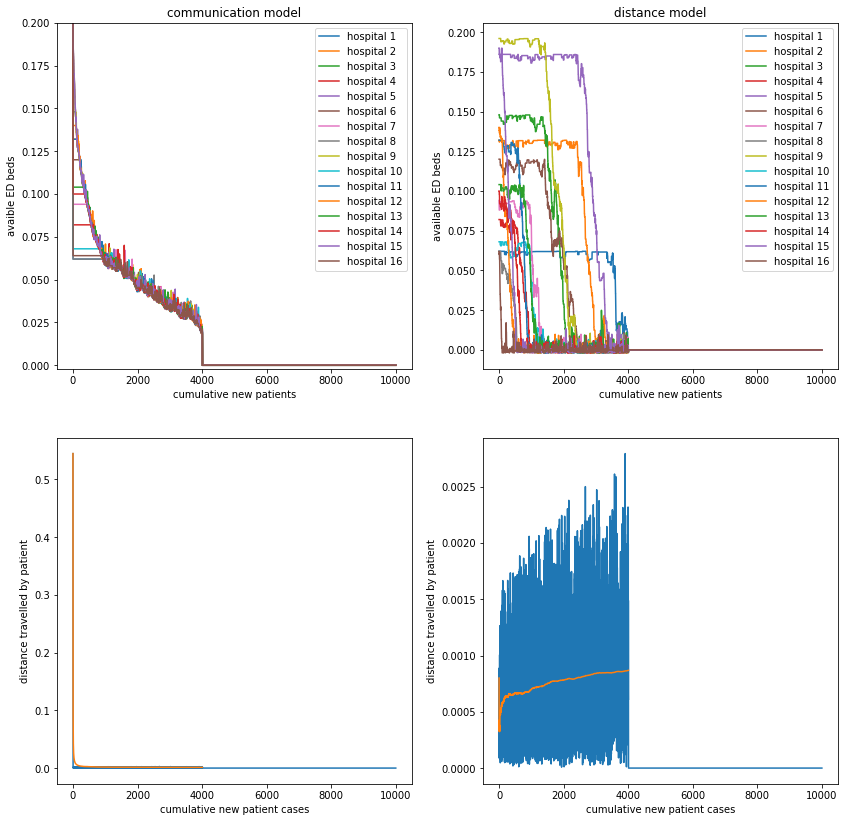

In [704]:
fig = plt.figure(figsize=(14,14))

nP = 10000
nH = 16
nT = 500

metadata = {}
# create hospitals
for i in range(int(np.sqrt(nH))):
    for j in range(int(np.sqrt(nH))):
        name = 'h'+str(i)+str(j)
        metadata[name] = {'location': (np.linspace(0,1,int(nH/2))[i],np.linspace(0,1,int(nH/2))[j]), 
                          'ED': {'max_beds': np.random.randint(30,100)}, 
                          'ICU': {'max_beds': np.random.randint(20,75), 
                          'max_ventilators': np.random.randint(10,40)} }

city1 = City(metadata=metadata)
city2 = City(metadata=metadata)
edwt, dwt, edwtN, dwtN = simulate(city1,city2=city2)

print('average fail, communication model: ' + str(np.where(dwt==0)[0][0]))
print('average fail, distance model: ' + str(np.where(dwtN==0)[0][0]))

print('total patient care, communication model: ' + str(np.round(np.sum(edwt))))
print('total patient care, distance model: ' + str(np.round(np.sum(edwtN))))

ax = fig.add_subplot(221)
for i in range(nH):
    ax.plot(edwt[i],label='hospital '+str(i+1))

ax.legend()
ax.set_ylabel('avaible ED beds')
ax.set_xlabel('cumulative new patients')
ax.set_title('communication model')
ax.set_ylim([np.min([edwt,edwtN]),0.2])#np.max([edwt,edwtN])])

ax = fig.add_subplot(222)
for i in range(nH):
    ax.plot(edwtN[i],label='hospital '+str(i+1))

ax.legend()
ax.set_ylabel('available ED beds')
ax.set_xlabel('cumulative new patients')
ax.set_title('distance model')
#ax.set_ylim([np.min([edwt,edwtN]),1])#np.max([edwt,edwtN])])

ax = fig.add_subplot(223)
ax.plot(dwt)
end = np.where(dwt==0)[0][0]
ax.plot(np.cumsum(dwt[0:end])/np.linspace(1,end,end))
ax.set_ylabel('distance travelled by patient')
ax.set_xlabel('cumulative new patient cases')
#ax.set_ylim([np.min([dwt,dwtN]),np.max([dwt,dwtN])])

ax = fig.add_subplot(224)
ax.plot(dwtN)
end = np.where(dwtN==0)[0][0]
ax.plot(np.cumsum(dwtN[0:end])/np.linspace(1,end,end))
ax.set_ylabel('distance travelled by patient')
ax.set_xlabel('cumulative new patient cases')
#ax.set_ylim([np.min([dwt,dwtN]),np.max([dwt,dwtN])])

pass